https://inside-machinelearning.com/en/why-and-how-to-normalize-data-object-detection-on-image-in-pytorch-part-1/

# Loading data

First of all we will load the data we need.

We use for that the datasets module.

It’s a module integrated to PyTorch that allows to quickly load datasets. Ideal to practice coding !

The dataset that interests us is called CIFAR-10. It is composed of 60 000 images in RGB color and size 32×32.
They are divided into 10 classes (plane, automobile, bird, cat, deer, dog, frog, horse, boat, truck), with 6 000 images per class

In [2]:
from torchvision import datasets
from torchvision import transforms
import os

data_path = os.path.join(os.getcwd(), 'cifar10')

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.ToTensor()
    )

100.0%


Extracting /app/One-Class-Audio-Classifier/cifar10/cifar-10-python.tar.gz to /app/One-Class-Audio-Classifier/cifar10


# Verifying the data

Let’s be a bit more precise, we have a variable cifar10 which is a dataset containing tuples.

These tuples are composed of :

a tensor (which represents the image)
an int which represents the label of the image

In [7]:
img_t, index_label = cifar10[5]
type(img_t), type(index_label)

(torch.Tensor, int)

We have recovered one of the images of the dataset, let’s display it !

We recall that an image tensor is in the format Color X Height X Width. To display the image, it is necessary to change its format to Height X Width X Color.

To do so, we use the permute() function.

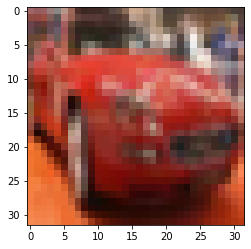

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

We also may display the label associated with the image:

The index_label variable is equal to 1. In fact we have retrieved the index that will allow us to know the name of the label.

In [6]:
index_label

1

# Normalization

Normalizing data is a step often forgotten by Data Scientists, even though it is essential to build a good Machine Learning algorithm.

Normalization is the fact of modifying the data of each channel/tensor so that the mean is zero and the standard deviation is one.

We show you an example with the normalization of a list below :

We show you an example below with the normalization of a list below…

…first, we calculate the mean and the standard deviation :

In [8]:
import numpy as np

l = [60, 9, 37, 14, 23, 4]
np.mean(l), np.std(l)

l_norm = [(element - np.mean(l)) / np.std(l) for element in l]
print(l_norm)

[1.8583670796659157, -0.8113997108400477, 0.6543546055161675, -0.5496578686335807, -0.07852255266194011, -1.0731415530465147]


We can check that the mean is 0 and the standard deviation is 1:

In [9]:
np.mean(l_norm), np.std(l_norm)

(0.0, 1.0)

# The PyTorch advantage

## Normalize Data Manually

With PyTorch we can normalize our data set quite quickly.

We are going to create the tensor channel we talked about in the previous part.

To do this, we use the stack() function by indicating each of the tensors in our cifar10 variable :

In [16]:
import torch

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

We obtain a channel that contains 50 000 images in 3x32x32 format.

In fact this channel is a tensor. It is a tensor which contains other tensors 😉

Thanks to this channel, we can calculate the average and standard deviation of all the tensors :

In [28]:
print('mean = ' +  str(imgs.view(3, -1).mean(dim=1)))
print('std = ' + str(imgs.view(3, -1).std(dim=1)))

mean = tensor([0.4914, 0.4822, 0.4465])
std = tensor([0.2470, 0.2435, 0.2616])


No need to rewrite the normalization formula, the PyTorch library takes care of everything!

We simply use the Normalize() function of the transforms module by indicating the mean and the standard deviation :



In [29]:
norm = transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

We can then normalize all images of the channel at the same time:

In [30]:
imgs_norm = torch.stack([norm(img_t) for img_t, _ in cifar10], dim=3)

Finally we can verify that our channel is well normalized with a mean of 0 and a standard deviation of 1 :

In [31]:
print(imgs_norm.mean(), imgs_norm.std())

tensor(-0.0007) tensor(1.0000)


## Barks audio normalization

In [33]:
import os
import librosa

audio_dir = os.path.join(os.getcwd(), 'barks_10s')
audio_path = os.path.join(audio_dir, 'bark_1.wav')

audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast') 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfcc_mean = np.mean(mfccs,axis=1)   

In [37]:
from utils.CustomAudioDataset import CustomAudioDataset
from utils.train_test_dataset import train_test_dataset

annotation_file = os.path.join(os.getcwd(), 'barks_10s.csv')

barks_dataset = CustomAudioDataset(annotations_file = annotation_file, audio_dir = audio_dir)    
barks = torch.stack([barks_t for barks_t, _ in barks_dataset])

In [38]:
print(barks.shape)

torch.Size([472, 40, 431])


In [50]:
barks_mean = np.mean(barks.cpu().detach().numpy(),axis=(0,2))
barks_std = np.std(barks.cpu().detach().numpy(),axis=(0,2))

In [70]:
barks_norm = []

for mfcc in range(barks.shape[1]):
    #print(barks[:, mfcc, :].shape)
    #print(barks_mean[mfcc])
    #print(barks_std[mfcc])
    barks_norm.append((barks[:, mfcc, :] - barks_mean[mfcc]) / barks_std[mfcc])

barks_norm = torch.stack(barks_norm, dim=1)
print(barks_norm.shape)

torch.Size([472, 40, 431])


In [72]:
for mfcc in range(barks_norm.shape[1]):
    print(np.mean(barks_norm[:, mfcc, :].cpu().detach().numpy()))
    print(np.std(barks_norm[:, mfcc, :].cpu().detach().numpy()))

3.4023097e-07
0.9999997
8.640787e-07
0.9999998
-3.1502868e-08
0.9999999
-2.9432678e-07
1.0000001
-1.5181382e-07
0.9999999
2.3702158e-08
1.0000001
-5.4004916e-09
0.99999964
-6.2795715e-07
1.0
-4.7164295e-07
0.9999999
3.1682885e-07
1.0000001
-2.0851898e-08
0.9999999
-7.2306584e-08
1.0
6.206815e-08
0.9999998
1.3351216e-07
1.0
-4.800437e-09
1.0
-1.0095919e-07
0.9999998
8.378262e-08
1.0000002
-5.5205025e-08
1.0000001
-2.3462135e-07
0.9999998
-4.7629335e-08
0.9999999
1.800164e-08
1.0000001
1.4101284e-08
1.0
1.0800983e-08
1.0000001
-3.1952908e-08
1.0000002
2.1001911e-08
1.0
-5.4004916e-09
1.0000001
-2.8202567e-08
0.9999998
-5.82053e-08
0.99999994
4.492909e-08
1.0
-3.7503414e-10
1.0000001
4.9504507e-08
0.9999999
3.000273e-10
1.0000002
-1.1566053e-07
0.9999998
-3.07528e-08
1.0000001
-1.3771253e-07
0.9999999
-7.4706804e-08
0.99999976
1.1566053e-07
0.99999976
7.110647e-08
1.0
-2.4842262e-07
0.99999964
2.4902267e-08
0.9999998


In [73]:
for sample in barks_norm:
    print(sample.shape)

torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size([40, 431])
torch.Size